# Estimate Important Component Temperatures
Avoid overheating at any time

# Introduction
The main purpose of the data set's recording is to be able to model the stator and rotor temperatures of a PMSM in real-time. Due to the intricate structure of an electric traction drive, direct measurement with thermal sensors is not possible for rotor temperatures, and even in case of the stator temperatures, sensor outage or even just deterioration can't be administered properly without redundant modeling. In addition, precise thermal modeling gets more and more important with the rising relevance of functional safety.

Your task is to design a model with appropriate feature engineering, that estimates four target temperatures in a causal manner (no future values should be considered for actual predictions). In order to maintain real-time capability, model sizes should be as small as possible. Note that temperature estimation in production will be deployed on best-cost hardware of traction drives in an automotive environment, where lean computation and lightweight implementation is key.

# Details
<span style="color:blue">Target features:
stator_yoke
stator_winding
stator_tooth
pm
</span>
# Input features:
The remaining features exclusive torque.
Torque is a quantity, which is not reliably measurable in field applications, such that this feature shall be omitted in this task.

# Cross-validation
Profile no. 65 and 72 denote the test set, the rest is for training.

# Expected Submission
Submit a notebook, where the complete pipeline from pre-processing, feature-engineering, model training, and prediction on profiles 65 and 72 is conducted.

# Evaluation
A good solution does

causal predictions (contemplate only past and current values)
have a small model size (in terms of amount of parameters and lightweight execution)
predict stator_* and pm features with a very small MSE and a small maximum absolute deviation
Extra
An additional requirement could be to predict higher temperatures more accurate than low temperatures and have over-estimates more common than under-estimates in order to ensure avoidance of over-heating. These are secondary though due to the more difficult comparability.

A comprehensive csv files containing all measurement sessions and features.
Each row represents one snapshot of sensor data at a certain time step.
Sample rate is 2 Hz (One row per 0.5 seconds).
Distinctive sessions are identified with "profile_id".



Model I have used for the problems are

[**BASIC LINEAR REGRESSION**](#1)

[**MULTIPLE LINEAR REGRESSION**](#2)

[**PRINCIPAL COMPONENT REGRESSION**](#3)

[**K-NEAREST NEIGHBORHOOD REGRESSION**](#4)

[**POLYNOMIAL REGRESSION**](#5)


In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import matplotlib.pyplot as plt


In [45]:
df = pd.read_csv('pmsm_temperature_data.csv')
                 
df.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4


In [46]:
df.info()
df.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
 12  profile_id      998070 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


float64    12
int64       1
dtype: int64

In [47]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


In [48]:
df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

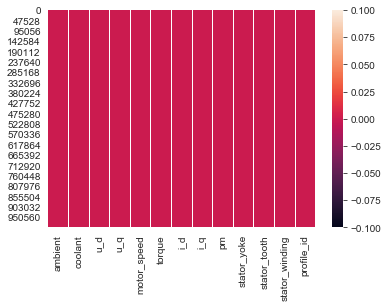

In [49]:
sns.heatmap(df.isnull())

In [54]:
#sns.set_style("whitegrid")
#sns.pairplot(df)

In [50]:
df.corr()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
ambient,1.000000,0.434435,0.194754,0.087430,0.078283,-0.262264,0.005605,-0.260562,0.501496,0.451616,0.396742,0.301883,0.384565
coolant,0.434435,1.000000,0.178708,0.027851,-0.033332,-0.189617,0.108489,-0.186060,0.430548,0.874037,0.689003,0.509298,0.499669
u_d,0.194754,0.178708,1.000000,-0.027472,-0.233828,-0.821325,0.358517,-0.796586,-0.082564,0.041428,-0.066256,-0.150714,0.300771
u_q,0.087430,0.027851,-0.027472,1.000000,0.716897,-0.037262,-0.181855,-0.026348,0.101236,0.106186,0.149017,0.125445,-0.122260
motor_speed,0.078283,-0.033332,-0.233828,0.716897,1.000000,0.024517,-0.722914,0.006323,0.332419,0.182564,0.333909,0.393154,-0.166225
torque,-0.262264,-0.189617,-0.821325,-0.037262,0.024517,1.000000,-0.239059,0.996560,-0.072905,-0.092207,-0.011055,0.080981,-0.257446
i_d,0.005605,0.108489,0.358517,-0.181855,-0.722914,-0.239059,1.000000,-0.204230,-0.299227,-0.179903,-0.387712,-0.539924,0.142368
i_q,-0.260562,-0.186060,-0.796586,-0.026348,0.006323,0.996560,-0.204230,1.000000,-0.086486,-0.098753,-0.025191,0.060949,-0.256127
pm,0.501496,0.430548,-0.082564,0.101236,0.332419,-0.072905,-0.299227,-0.086486,1.000000,0.695014,0.768352,0.729561,0.156735
stator_yoke,0.451616,0.874037,0.041428,0.106186,0.182564,-0.092207,-0.179903,-0.098753,0.695014,1.000000,0.949898,0.845144,0.398021


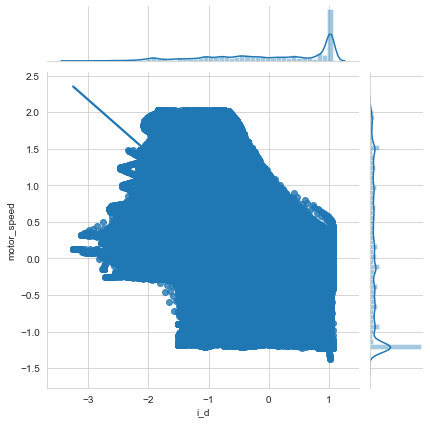

In [53]:
sns.jointplot(x='i_d', y='motor_speed', data=df, kind='reg')

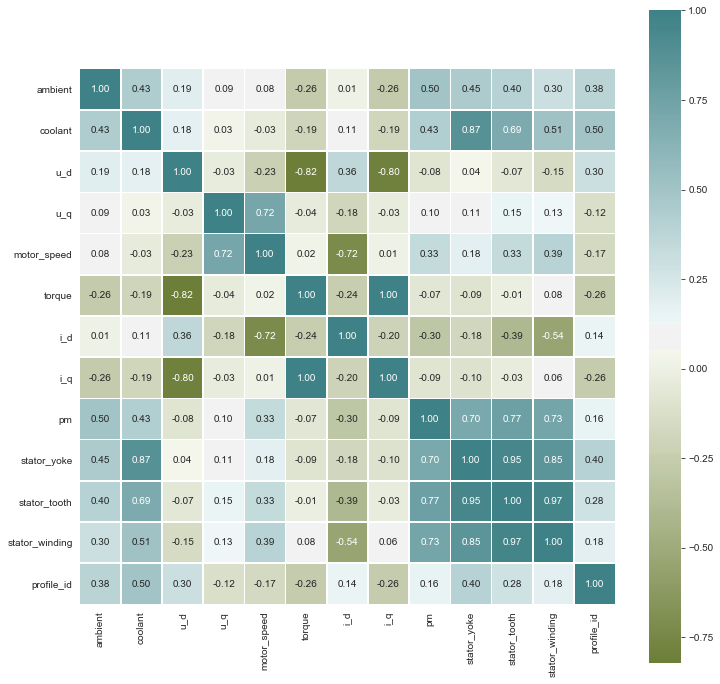

In [55]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=df.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', 
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

There are high correlation between values.

<a id= "1" ></a><br>**BASIC LINEAR REGRESSION**

In [57]:
import statsmodels.api as sm

In [76]:
#Defining dependent and independent variable
X = df['i_d']
X=sm.add_constant(X)

y = df['motor_speed']

In [77]:
lm=sm.OLS(y,X)
model=lm.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            motor_speed   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                 1.093e+06
Date:                Wed, 01 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:01:50   Log-Likelihood:            -1.0484e+06
No. Observations:              998070   AIC:                         2.097e+06
Df Residuals:                  998068   BIC:                         2.097e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -2.826      0.005      -0.003      -0.001
i_d           -0.7245      0.001  -1045.267      0.000      -0.726      -0.723
==============================================================================
Omnibus:                     7561.278   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5931.452
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                       2.691   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
model.params

const   -0.001957
i_d     -0.724531
dtype: float64

In [64]:
model.mse_model #mean squared error is too much. It is not good.

522878.4007176551

In [65]:
model.rsquared #Not bad

0.5226043734324983

In [66]:
model.rsquared_adj #Not bad

0.522603895112758

In [67]:
model.fittedvalues[0:5] #Predicted values

0   -0.747914
1   -0.747869
2   -0.747824
3   -0.750285
4   -0.749534
dtype: float64

In [68]:
y[0:5] #Real values

0   -1.222428
1   -1.222429
2   -1.222428
3   -1.222430
4   -1.222429
Name: motor_speed, dtype: float64

In [69]:
#Model equation
print("Motor speed = " + 
      str("%.3f" % model.params[0]) + ' + i_d' + "*" + 
      str("%.3f" % model.params[1]))

Motor speed = -0.002 + i_d*-0.725


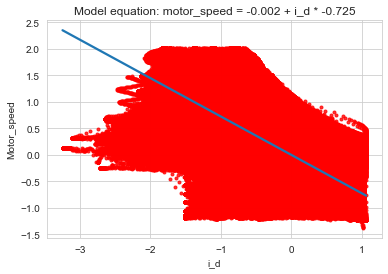

In [70]:
#Model Visualization 
g=sns.regplot(df['i_d'] , df['motor_speed'], 
              ci=None, scatter_kws={'color': 'r', 's':9})
g.set_title('Model equation: motor_speed = -0.002 + i_d * -0.725')
g.set_ylabel('Motor_speed')
g.set_xlabel('i_d');

In [71]:
from sklearn.metrics import r2_score,mean_squared_error

In [72]:
mse=mean_squared_error(y, model.fittedvalues)
rmse=np.sqrt(mse)
rmse

0.6917872418443057

In [73]:
k_t=pd.DataFrame({'Real_values':y[0:50], 
                  'Predicted_values' :model.fittedvalues[0:50]})
k_t['error']=k_t['Real_values']-k_t['Predicted_values']
k_t.head()

,Real_values,Predicted_values,error
0,-1.222428,-0.747914,-0.474514
1,-1.222429,-0.747869,-0.474561
2,-1.222428,-0.747824,-0.474604
3,-1.222430,-0.750285,-0.472145
4,-1.222429,-0.749534,-0.472895


In [74]:
model.resid[0:10] #It is easy way to learn residuals.

0   -0.474514
1   -0.474561
2   -0.474604
3   -0.472145
4   -0.472895
5   -0.473457
6   -0.473848
7   -0.474130
8   -0.474315
9   -0.474471
dtype: float64

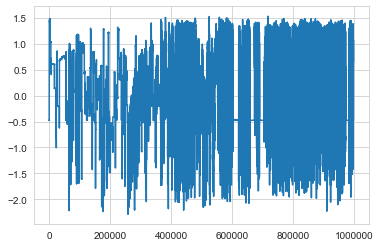

In [75]:
plt.plot(model.resid);

<a id= "2" ></a><br>**MULTIPLE LINEAR REGRESSION**

In [79]:
X=df.drop("motor_speed", axis=1)
y=df["motor_speed"]

In [80]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict


In [81]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

training=df.copy()

In [82]:
lm=sm.OLS(y_train, X_train)

model=lm.fit()
model.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            motor_speed   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          8.582e+05
Date:                Wed, 01 Jul 2020   Prob (F-statistic):                        0.00
Time:                        20:10:07   Log-Likelihood:                         -83308.
No. Observations:              798456   AIC:                                  1.666e+05
Df Residuals:                  798444   BIC:                                  1.668e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ambient           -0.0503      0.000   -131.429      0.000      -0.051      -0.050
coolant            0.4091      0.002    218.100      0.000       0.405       0.413
u_d               -0.1657      0.001   -254.611      0.000      -0.167      -0.164
u_q                0.5394      0.000   1469.606      0.000       0.539       0.540
torque            -0.3411      0.005    -70.287      0.000      -0.351      -0.332
i_d               -0.6580      0.001  -1268.145      0.000      -0.659      -0.657
i_q                0.1352      0.005     29.630      0.000       0.126       0.144
pm                 0.1061      0.001    170.646      0.000       0.105       0.107
stator_yoke       -1.6278      0.006   -282.304      0.000      -1.639      -1.617
stator_tooth       2.3219      0.008    304.592      0.000       2.307       2.337
stator_winding    -1.1714      0.004   -310.271      0.000      -1.179      -1.164
profile_id     -1.117e-05    5.6e-06     -1.995      0.046   -2.22e-05   -1.96e-07
==============================================================================
Omnibus:                    43472.517   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169112.669
Skew:                          -0.111   Prob(JB):                         0.00
Kurtosis:                       5.244   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
#Root Mean Squared Error for Train
rmse1=np.sqrt(mean_squared_error(y_train,model.predict(X_train)))
rmse1

0.2685809987166384

In [84]:
#Root Mean Squared Error for Test
rmse2=np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
rmse2

0.2682375919182859

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
#Model Tuning for Multiple Linear Regression
model = LinearRegression().fit(X_train,y_train)
cross_val_score1=cross_val_score(model, X_train, y_train, cv=10, scoring='r2').mean() #verified score value for train model
print('Verified R2 value for Training model: ' + str(cross_val_score1))

cross_val_score2=cross_val_score(model, X_test, y_test, cv=10, scoring='r2').mean() #verified score value for test model
print('Verified R2 value for Testing Model: ' + str(cross_val_score2))

Verified R2 value for Training model: 0.9280570425519296
Verified R2 value for Testing Model: 0.9281973950061891


In [88]:
RMSE1=np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, 
                               scoring='neg_mean_squared_error')).mean() #verified RMSE score value for train model
print('Verified RMSE value for Training model: ' + str(RMSE1))

RMSE2=np.sqrt(-cross_val_score(model, X_test, y_test, cv=10, 
                               scoring='neg_mean_squared_error')).mean() #verified RMSE score value for test model
print('Verified RMSE value for Testing Model: ' + str(RMSE2))

Verified RMSE value for Training model: 0.2685584755640468
Verified RMSE value for Testing Model: 0.2682294742267721


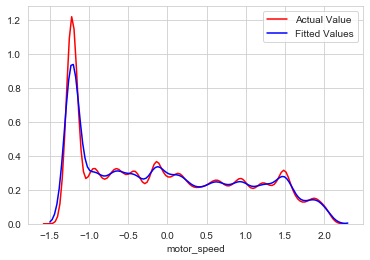

In [89]:
#Visualizing for Multiple Linear Regression y values

import seaborn as sns
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);

<a id= "3" ></a><br>**PRINCIPAL COMPONENT REGRESSION**

In [93]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca=PCA()
X_reduced_train=pca.fit_transform(scale(X_train))

In [94]:
explained_variance_ratio=np.cumsum(np.round(pca.explained_variance_ratio_ , decimals=4)* 100)[0:20]

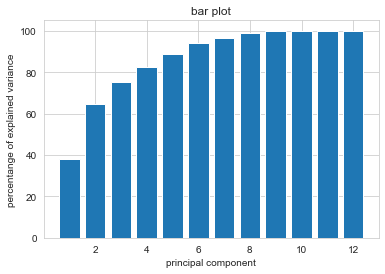

In [95]:
plt.bar(x=range(1, len(explained_variance_ratio)+1), height=explained_variance_ratio)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('bar plot')
plt.show()
# 7 component is enough for model.

In [96]:
lm=LinearRegression()
pcr_model=lm.fit(X_reduced_train,y_train)
print('Intercept: ' + str(pcr_model.intercept_))
print('Coefficients: ' + str(pcr_model.coef_))

Intercept: -0.00546127832814683
Coefficients: [-0.13248389  0.18798958  0.64978531 -0.24235563 -0.038966    0.34814071
 -0.01512341 -0.38662935 -0.30625748  0.14768885  0.59449755 -3.03336011]


In [97]:
#Prediction
y_pred=pcr_model.predict(X_reduced_train)
np.sqrt(mean_squared_error(y_train,y_pred))

0.268553922694838

In [98]:
df['motor_speed'].mean()

-0.006335507987812318

In [99]:
#R squared
r2_score(y_train,y_pred)

0.9280615197697045

In [100]:
# Prediction For testing error 
pca2=PCA()

X_reduced_test=pca2.fit_transform(scale(X_test))
pcr_model2=lm.fit(X_test,y_test)

y_pred=pcr_model2.predict(X_reduced_test)

print('RMSE for test model : ' +str(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE for test model : 1.6579608918029016


In [101]:
#Model Tuning for PCR

lm=LinearRegression()
pcr_model=lm.fit(X_reduced_train[:,0:10],y_train)
y_pred=pcr_model.predict(X_reduced_test[:,0:10])

from sklearn import model_selection

cv_10=model_selection.KFold(n_splits=10,
                           shuffle=True,
                           random_state=1)

In [102]:
lm=LinearRegression()
RMSE=[]

for i in np.arange(1,X_reduced_train.shape[1] + 1):
    score=np.sqrt(-1*model_selection.cross_val_score(lm,
                                                    X_reduced_train[:,:i],
                                                    y_train.ravel(),
                                                    cv=cv_10,
                                                    scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

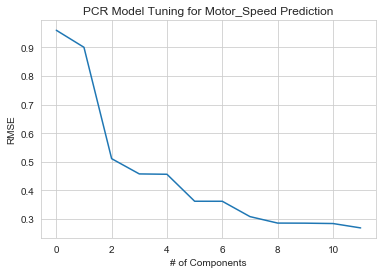

In [103]:
plt.plot(RMSE)
plt.xlabel('# of Components')
plt.ylabel('RMSE')
plt.title('PCR Model Tuning for Motor_Speed Prediction'); 

10 component is good for the model because RMSE value is the smallest for this component number. That's why there is no need to tune the model.

<a id= "4" ></a><br>**KNN REGRESSION**

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [106]:
knn_model=KNeighborsRegressor().fit(X_train, y_train)
y_pred=knn_model.predict(X_test)

In [107]:
y_pred.shape

(199614,)

In [108]:
#Model Tuning (learning best n_neighbors hyperparameter)
knn_params={'n_neighbors' : np.arange(1,5,1)}

knn=KNeighborsRegressor()
knn_cv_model=GridSearchCV(knn, knn_params, cv=5)

knn_cv_model.fit(X_train,y_train)
knn_cv_model.best_params_["n_neighbors"]

2

In [109]:
# Train error values from n=1 up n=2
RMSE=[]
RMSE_CV=[]
for k in range(2):
    k=k+1
    knn_model=KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    y_pred=knn_model.predict(X_train)
    rmse=np.sqrt(mean_squared_error(y_train,y_pred))
    rmse_cv=np.sqrt(-1*cross_val_score(knn_model,X_train,y_train,cv=2,
                                       scoring='neg_mean_squared_error').mean())

    RMSE.append(rmse)
    RMSE_CV.append(rmse_cv)

    print("RMSE value: ", rmse, 'for k= ',k,
          "RMSE values with applying Cross Validation: ", rmse_cv)

RMSE value:  0.0 for k=  1 RMSE values with applying Cross Validation:  0.0391356161728771
RMSE value:  0.01454401830556433 for k=  2 RMSE values with applying Cross Validation:  0.03771565668468597


In [110]:
#Model Tuning according to best parametre for KNN Regression
knn_tuned=KNeighborsRegressor(n_neighbors=knn_cv_model.best_params_["n_neighbors"])
knn_tuned.fit(X_train,y_train)
np.sqrt(mean_squared_error(y_test,knn_tuned.predict(X_test)))

0.02554626491850223

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

<a id= "5" ></a><br> **POLYNOMIAL REGRESSION**

In [113]:
quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X_train)

X_train,X_test,y_train,y_test = train_test_split(x_quad,y_train, random_state = 0)

plr = LinearRegression().fit(X_train,y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print('Polynomial Linear Regression:' ,plr.score(X_test,y_test))

Polynomial Linear Regression: 0.9952573854207651


Coefficients: 
 [-1.19652298e-12 -1.94751304e-03  8.86767668e-02 -1.51002720e-01
  8.46456963e-01 -4.33513690e-01 -4.11436417e-01  2.67644301e-01
  1.87790064e-02 -1.25988463e-01 -1.71853359e-01  2.54897914e-01
  7.40823232e-04 -4.34110557e-03 -3.24485408e-02  1.34249919e-02
 -1.05690117e-04  1.67560244e-01  8.52062538e-03 -1.56724820e-01
 -1.89292501e-03  5.46155535e-02 -9.53354640e-03 -1.36632243e-02
  2.28461480e-05  6.35750499e-02 -1.63781265e-01 -5.32017845e-02
 -9.07557261e-01 -5.67804823e-02  7.42197288e-01  1.03560119e-01
 -4.73717311e-01  3.83839811e-01 -4.06039694e-02 -6.25699752e-04
  1.38771773e-01  3.68937154e-02 -8.83271855e-01  2.50808967e-02
  1.04897761e+00 -3.74045176e-02  6.23406019e-01 -6.54857489e-01
  1.79516489e-01 -1.55441855e-03 -4.59404937e-05 -3.55526844e-01
 -3.64804458e-01  2.34531508e-01 -3.94524138e-03  2.36891662e-01
 -2.88885594e-01  1.08053335e-01 -3.56503666e-04  7.56339301e-01
  7.49643580e-01 -3.33692091e+00 -3.06318572e-01  4.23305718e+00
 -5.39802

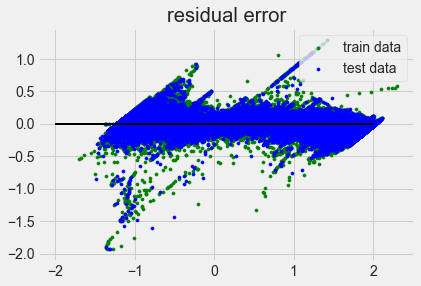

In [114]:
#Plotting Residual in Linear Regression 

from sklearn import linear_model,metrics
#Create linear regression object
reg=linear_model.LinearRegression()

#train the model using the train data sets
reg.fit(X_train,y_train)

#regression coefficients
print("Coefficients: \n", reg.coef_)

#Variance score
print("Variance score: {}".format(reg.score(X_test,y_test)))

plt.style.use('fivethirtyeight')

#plotting residual errors in training data
plt.scatter(reg.predict(X_train),reg.predict(X_train)-y_train, 
            color="green", s=10, label="train data")

#plotting residual errors in test data
plt.scatter(reg.predict(X_test),reg.predict(X_test)-y_test, 
            color="blue", s=10, label="test data")

#plot line for zero residual error
plt.hlines(y=0,xmin=-2, xmax=2, linewidth=2)

#plot legend
plt.legend(loc='upper right')

#plot title
plt.title("residual error")

plt.show()